# L5d: Kernelized Support Vector Machines (kSVMs)
Fill me in

### Theory: Support Vector Machine (SVM)
Suppose, we have dataset $\mathcal{D} = \{(\hat{\mathbf{x}}_{i}, y_{i}) \mid i = 1,2,\dots,n\}$, where $\hat{\mathbf{x}}_i \in \mathbb{R}^p$ is an _augmented_ feature vector ($m$ features with additional `1` to model the bias on the end of the vector) and $y_i \in \{-1, 1\}$ is the corresponding class label.
* __Objective__: the goal of an SVM is to find the hyperplane $\mathcal{H}(\hat{\mathbf{x}}) = \{\hat{\mathbf{x}} \mid \left<\hat{\mathbf{x}},\theta\right> = 0\}$ that separates the data points into two classes (those points above the hyperplane, and those points below the hyperplane), 
where $\theta \in \mathbb{R}^{p}$ ($p=m+1$) is the normal vector to the hyperplane, or alternatively, the parameters of the model that we need to estimate.
* __Why another method__? Support vector machines (SVMs) and other approaches, e.g., [the perceptron](https://en.wikipedia.org/wiki/Perceptron) differ primarily in their optimization objectives and training methods: while a [perceptron](https://en.wikipedia.org/wiki/Perceptron) can find _a hyperplane_ that separates classes, SVMs seek to find the _best hyperplane_ in the sense that the _margin_ between classes is maximized.

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

### Data
First, let's set the number of samples `N` that we have in the data set $\mathcal{D}$, and the number of feature variables `n`, i.e., the number of elements of $\mathbf{x}\in\mathbb{R}^{n}$.

In [5]:
number_of_points_per_label = 1000; # number of samples per label (2 x this is the total)
number_of_training_examples = 1200; # pick this many training examples at random
number_of_features = 6; # we have this many features
ϵ = 0.80; # threshold of random NLS points to accept

Let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

Next, let's write a code to generate a [non-lineraly separable data set](https://en.wikipedia.org/wiki/Linear_separability) $\mathcal{D}$ that we'll use to train (and test) our [kSVM](https://en.wikipedia.org/wiki/Support_vector_machine#Nonlinear_kernels).
* To do this, let's generate random points and check the $y\cdot\left(\mathbf{w}^{T}\cdot\mathbf{x}\right) > 0$ condition. If this condition is true, we `accept` that data; otherwise, we `reject` the data. If we `accept` the data, we store it in the `dataset` variable, a [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Set) holding a [NamedTuple type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple), which is a mix of a tuple and a dictionary.
* We keep iterating the loop until the number of elements of the `dataset` is greater than or equal to the desired number of test points specified in the `N` variable.

In [9]:
D = let

    # initialize 
    dataset = Set{@NamedTuple{x::Array{Float64,1},y::Int64}}();
    w = randn(number_of_features+1); # tmp parameters that we use to make data
    classes = [-1,1]; # binary classes
    # d = Categorical([0.51,0.49]);
    should_keep_looping = true;
    
    while (should_keep_looping == true)
    
        x = randn(number_of_features) |> x -> push!(x,1); # generate a random augmented feature vector
        y = 1;
        
        # check -
        if (y*(sum(w.*x)) ≥ 0.0)
            data = (x = x, y = y); # use a tuple, and set to enforce unique
            push!(dataset,data);
        else
            # fails, should we keep this data?
            if (rand() ≥ ϵ)
                data = (x = x, y = y); # use a tuple, and set to enforce unique
                push!(dataset,data);
            end
        end
    
        # if we have enough examples, stop iterating
        if (length(dataset) >= number_of_points_per_label)
            should_keep_looping = false
        end
    end

    should_keep_looping = true;
    while (should_keep_looping == true)
    
        x = randn(number_of_features) |> x -> push!(x,1); # generate a random augmented feature vector
        y = -1;
        
        # check -
        if (y*(sum(w.*x)) ≥ 0.0)
            data = (x = x, y = y); # use a tuple, and set to enforce unique
            push!(dataset,data);
        else
            # fails, should we keep this data?
            if (rand() ≥ ϵ)
                data = (x = x, y = y); # use a tuple, and set to enforce unique
                push!(dataset,data);
            end
        end
    
        # if we have enough examples, stop iterating
        if (length(dataset) >= 2*number_of_points_per_label)
            should_keep_looping = false
        end
    end

    @show length(dataset)

    # ok, so let's put this data into a matrix -
    D = Array{Float64,2}(undef, 2*number_of_points_per_label, number_of_features+1);
    for i ∈ 1:2*number_of_points_per_label
        example = pop!(dataset);
        feature = example.x;
        label = example.y;
        for j ∈ 1:number_of_features
            D[i,j] = feature[j];
        end
        D[i,end] = label;
    end
    D
end

length(dataset) = 2000


2000×7 Matrix{Float64}:
  0.366608   -1.8518      0.0453876   …   0.928255     0.973175  -1.0
  0.569287    0.16533    -0.699301       -1.19719      0.788789  -1.0
 -0.0333475  -0.301728   -0.84503         1.56218     -1.57878    1.0
  0.462384    0.103008    0.00122587     -1.58468      0.18515   -1.0
  0.57401     0.33464     2.618          -0.0346364    0.563698  -1.0
  1.88476     0.117542    0.467889    …   1.04374     -0.625174   1.0
 -1.52623     0.434367    1.30079         1.12978      1.16804    1.0
 -0.948837    1.1789     -0.565499        0.331576     2.24       1.0
  0.960255    0.562334    0.359629        1.38792     -0.363901  -1.0
  0.731789   -0.0437454   1.89726         0.17276     -0.216853  -1.0
 -0.260946   -1.23813     1.5371      …   0.472599    -0.361515   1.0
 -1.60839     0.781026    0.436826        0.00838269  -0.402502   1.0
 -1.52778     1.50594     0.280307       -1.62057     -0.549524  -1.0
  ⋮                                   ⋱                ⋮         


### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D`, which contains two continuous features and a label. The color indicates the label.
* __Summary__: We will get a different pattern of $\pm{1}$ labels depending on radius $r_{1}$ and $r_{2}$ values, and any additional labeling logic $L(x,y)$ we used. The dark blue dots represent label `1`, while the orange data represents label `1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

In [11]:
let

    dataset = D; # what dataset am I looking at?
    number_of_points_to_plot = size(dataset,1);
    if (number_of_features > 2)
        @info "Visualization disabled"
    else
        p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
        # plot label = 1
        testlabel = 1;
        i = findfirst(label -> label == testlabel,  dataset[:,3])
        c = my_color_dictionary[testlabel]
        scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)
    
        # plot label = -1
        testlabel = -1;
        i = findfirst(label -> label == testlabel,  dataset[:,3])
        c = my_color_dictionary[testlabel]
        scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)
    
        # plot all points
        for i ∈ 1:number_of_points_to_plot
            label = dataset[i,3]; # label
            c = my_color_dictionary[label]
            scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
        end
        
        xlabel!("Feature 1 (AU)", fontsize=18);
        ylabel!("Feature 2 (AU)", fontsize=18);
    end
end

[ Info: Visualization disabled


In [12]:
training, test = let

    number_of_features = size(D,2); # number of cols of housing data
    number_of_examples = size(D,1); # number of rows of housing data
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

## Task 2: Classification using an SVM
In this task, we [use the SVM implementation exported by the `LIBSVM.jl` package](https://github.com/JuliaML/LIBSVM.jl) to classify the [banknote authentication dataset from the UCI archive](https://archive.ics.uci.edu/dataset/267/banknote+authentication). In particular, we use the `training` dataset to estimate the unknown model parameters $\theta$ [using the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). 
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) takes a matrix of feature vectors where augmented training examples matrix $\hat{\mathbf{X}}^{\top}$, i.e., the examples are on the columns and the features are the rows, and a label vector $\mathbf{y}\in\left\{-1,1\right\}$.
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns a [model instance](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) that holds the trained data and a bunch of other data associated with the problem.
* __Hmmm__: One of the (super) interesting optional arguments [the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) is the `kernel` argument. Check out the documentation to see what kernels are supported! Wow! we get [kernelized SVM capability](https://en.wikipedia.org/wiki/Support_vector_machine#Nonlinear_kernels) right out of the box. Buy versus build, 99% buy!

In [14]:
model = let

    # Setup the data that we are using
    D = training; # what dataset are we looking at?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y = D[:,end]; # label

    # Train the data -
    model = svmtrain(X, y, kernel=LIBSVM.Kernel.RadialBasis, verbose = true); # we are using the LIBSVM

    # return
    model
end;

*
optimization finished, #iter = 936
nu = 0.559723
obj = -623.225616, rho = 0.103884
nSV = 713, nBSV = 627
Total nSV = 713


__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between an actual banknote and a forgery on data it has never seen. We run the classification operation on the (unseen) test data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). 
* The [`svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns the predicted label which we store in the `ŷ::Array{Int64,1}` array. We store the actual (correct) label in the `y::Array{Int64,1}` vector. 

In [16]:
ŷ,y,d = let

     # Setup the data that we are using
    D = test; # what dataset are we looking at?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y = D[:,end]; # label
    
    # Test model on the other half of the data.
    ŷ, decision_values = svmpredict(model, X);

    # return -
    ŷ,y,decision_values
end;

### Confusion Matrix
The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). [Click me for a confusion matrix schematic!](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf). Let's compute these four values [using the `confusion(...)` method](src/Compute.jl) and store them in the `CM::Array{Int64,2}` variable:

In [18]:
CM = confusion(y, ŷ) # call with the SVM values

2×2 Matrix{Int64}:
 325   77
  82  316

In [19]:
number_of_test_points = length(y);
correct_prediction_perceptron = CM[1,1] + CM[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.80125 Fraction incorrect 0.19874999999999998


## Task 3: Implement Grid Search for Optimal Hyperparameters
Fill me in

In [21]:
error, α, β = let
    
    # Training data setup -
    D₁ = training; # what dataset are we looking at?
    number_of_training_examples = size(D₁,1); # how many rows?
    X₁ = [D₁[:,1:end-1] ones(number_of_training_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y₁ = D₁[:,end]; # label

    # Test data setup -
    D₂ = test; # what dataset are we looking at?
    number_of_test_examples = size(D₂,1); # how many rows?
    X₂ = [D₂[:,1:end-1] ones(number_of_test_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y₂ = D₂[:,end]; # label
    
    α = range(-5,stop = 15, step=2) |> collect; # exponent for C -
    β = range(-15,stop = 3, step=2) |> collect; # exponent for γ -
    number_of_points_C = length(α);
    number_of_points_gamma = length(β);
    error = Array{Float64,2}(undef, number_of_points_C, number_of_points_gamma);
    
    for i ∈ eachindex(α)
        C = 2.0^α[i];
        for j ∈ eachindex(β)
            γ = 2.0^β[j];

            # train model -
            ŷ₂,_ = svmtrain(X₁, y₁, kernel=LIBSVM.Kernel.RadialBasis, 
                verbose = false, cost = C, gamma = γ) |> model -> svmpredict(model,X₂);

            # how many mistakes?
            CM = confusion(y₂, ŷ₂);
            correct_prediction_perceptron = CM[1,1] + CM[2,2];
            error[i,j] = (correct_prediction_perceptron/number_of_test_examples);
        end
    end
    
    error, α, β
end;

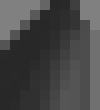

In [22]:
Gray.(1 .- error)

In [46]:
error

11×10 Matrix{Float64}:
 0.4975   0.4975   0.4975   0.4975   …  0.8375   0.75375  0.4975   0.4975
 0.4975   0.4975   0.4975   0.65        0.825    0.79625  0.4975   0.4975
 0.4975   0.4975   0.66375  0.83875     0.81875  0.79625  0.705    0.4975
 0.4975   0.66875  0.83875  0.84375     0.7875   0.7475   0.70375  0.56125
 0.66875  0.83875  0.84125  0.8425      0.77375  0.71125  0.7      0.56125
 0.83875  0.84125  0.84125  0.84125  …  0.7475   0.7075   0.7      0.56125
 0.84125  0.84125  0.84125  0.8325      0.725    0.68125  0.7      0.56125
 0.84125  0.84     0.8425   0.81625     0.705    0.67     0.7      0.56125
 0.84     0.84125  0.83375  0.80875     0.685    0.67     0.7      0.56125
 0.8425   0.84125  0.81625  0.8125      0.6675   0.67     0.7      0.56125
 0.84125  0.83375  0.81125  0.81     …  0.665    0.67     0.7      0.56125

In [24]:
coordinate = argmax(error)

CartesianIndex(4, 4)

In [25]:
C = coordinate[1] |> i-> α[i] |> e-> 2.0^e

2.0

In [26]:
γ = coordinate[2] |> i-> β[i] |> e-> 2.0^e

0.001953125